In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import torch

from transformers import AutoTokenizer
from datasets import load_dataset
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.nn.functional import cross_entropy
from app.modeling.model import TweetClassificationModel
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

## Load Data

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
emotions_ds = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
class_names = emotions_ds["train"].features["label"].names
class_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [5]:
MODEL_CHKPT = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHKPT)

tokenizer("this is a test in order to see if the encoder is working", return_tensors="pt")

{'input_ids': tensor([[  101,  2023,  2003,  1037,  3231,  1999,  2344,  2000,  2156,  2065,
          1996,  4372, 16044,  2099,  2003,  2551,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [6]:
def tokenize_batch(batch):
    return tokenizer(batch["text"], 
                     padding=True,
                     truncation=True,
                     add_special_tokens=True,
                     return_tensors="pt")

In [7]:
tweets_encoded = emotions_ds.map(tokenize_batch, batched=True, batch_size=None)

Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-b324fc8d9823e7f9.arrow
Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-1a6f8804dcb677d0.arrow
Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-3f93778ab3d480f2.arrow


In [8]:
tweets_encoded.set_format("torch",
                          columns=["input_ids", "attention_mask", "label"])

## Load Model

In [9]:
saved_model_name = "distilbert-base-finetuned-for-tweet-classification-with-random-oversampling_with_scheduler"

model = TweetClassificationModel(MODEL_CHKPT, len(class_names))
model.load_state_dict(
                torch.load(f"app/modeling/models/{saved_model_name}.pth")
            )
model = model.to(torch.device("mps"))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Evaluate the model

In [10]:
def forward_pass_with_label(batch):
    with torch.inference_mode():

        inputs = {k:v.to(torch.device("mps")) for k,v in batch.items() if k in tokenizer.model_input_names}

        output = model(input_ids = inputs["input_ids"],
                       attention_mask = inputs["attention_mask"],
                       labels=None)

        pred_label = torch.argmax(output["logits"], dim=1)

        loss = cross_entropy(input=output.logits, target=batch["label"].to(torch.device("mps")), reduction="none")

    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }

In [11]:
tweets_encoded["test"] = tweets_encoded["test"].map(forward_pass_with_label, batched=True, batch_size=16)

/Users/davidbreinl/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646991213/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(
Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-4d03d0fe14404367.arrow


In [12]:
tweets_encoded.set_format("pandas")

In [13]:
loss_df = tweets_encoded["test"][:][["text", "label",  "loss", "predicted_label"]]
loss_df["true_label"] = [class_names[sentiment] for sentiment in loss_df["label"]]
loss_df["predicted_label"] = [class_names[sentiment] for sentiment in loss_df["predicted_label"]]

In [14]:
loss_df.sort_values("loss", ascending=False).head(30)

,text,label,loss,predicted_label,true_label
1382,i cannot even begin to express in words the depth of sorrow that i feel having not posted any of my ludicrous rants over the passed days,5,7.550691,sadness,surprise
125,i feel very mislead by someone that i really really thought i knew and liked very much so,2,6.868083,anger,love
1253,i don t feel betrayed coz the backstabber had no grounds for their accusation but i m just amazed at some people s ability to do such things,5,6.330835,sadness,surprise
816,whenever i put myself in others shoes and try to make the person happy,3,6.219223,joy,anger
1613,i feel very cheated since i am supporting the family and doing all the other stuff while he spends hours a day gaming,1,5.024529,sadness,joy
193,i really dont like quinn because i feel like she will just end up hurting barney and i hated the lame ted robin storyline,3,4.967417,sadness,anger
1479,i really feel and i know the devil hates that its always been something he could use against me and im determined not to let him,1,4.848154,sadness,joy
1837,i hate these feelings in my heart i hate that work stressed me out i hate that cornelius wont let me get my way im frustrated lord,0,4.672487,anger,sadness
426,i feel unprotected a class post count link href http reprogramming in process,0,4.470316,fear,sadness
1425,i see the look of doubt on your face i feel the scorn in your eyes but for anyone skeptical of grits dinner grits please see this as a totally amazing sister to mashed potatoes,4,4.403206,anger,fear


In [15]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

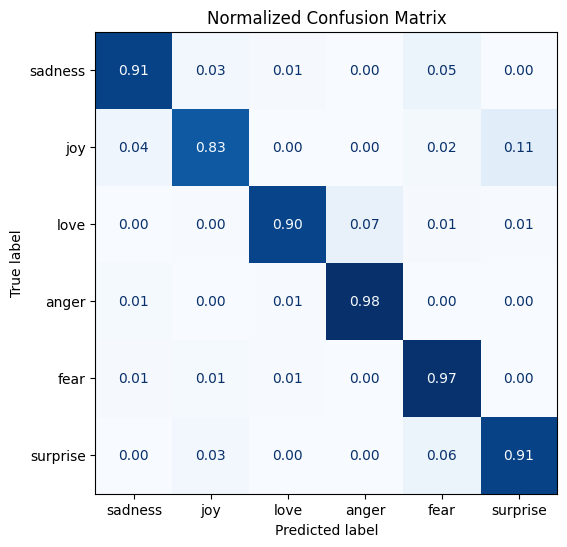

In [16]:
plot_confusion_matrix(loss_df["predicted_label"], loss_df["true_label"], labels=class_names)

In [17]:
recall = recall_score(loss_df["true_label"], loss_df["predicted_label"], average="weighted")
precision = precision_score(loss_df["true_label"], loss_df["predicted_label"], average="weighted")
accuracy = accuracy_score(loss_df["true_label"], loss_df["predicted_label"])
f1_score = f1_score(loss_df["true_label"], loss_df["predicted_label"], average="weighted")

In [18]:
pd.DataFrame({"precision": precision,
              "recall": recall,
              "f1": f1_score,
              "accuracy": accuracy}, 
              index=[saved_model_name])

,precision,recall,f1,accuracy
distilbert-base-finetuned-for-tweet-classification-with-random-oversampling_with_scheduler,0.930168,0.9215,0.923141,0.9215
